# TBD Phase 2: Performance & Computing Models

## Introduction
In this lab, you will compare the performance and computing models of four popular data processing engines: **Polars, Pandas, DuckDB, and PySpark**.

You will explore:
- **Performance**: Single-node processing speed, parallel execution, and memory usage.
- **Scalability**: How performance changes with the number of cores (single-node) and executors (cluster).
- **Computing Models**: Out-of-core vs. In-memory processing, and Eager vs. Lazy execution.

### Engine Capabilities
The following table summarizes the key capabilities of the engines we will be testing. Use this as a reference.

| Engine | Query Optimizer | Distributed | Arrow-backed | Out-of-Core | Parallel | APIs | GPU Support |
|---|---|---|---|---|--|---|---|
| **Pandas** | ❌ | ❌ | optional ≥ 2.0 | ❌ | ❌ | DataFrame | ❌ |
| **Polars** | ✅ | ❌ | ✅ | ✅ | ✅ | DataFrame | ✅ (opt) |
| **PySpark** | ✅ | ✅ | Pandas UDF/IO | ✅ | ✅ | SQL, DataFrame | ❌ (no GPU) |
| **DuckDB** | ✅ | ❌ | ✅ | ✅ | ❌ | SQL, Relational API | ❌ |

## Prerequisites
Ensure you have the necessary libraries installed.

In [3]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            15Gi       899Mi        13Gi       0.0Ki       1.2Gi        14Gi
Swap:             0B          0B          0B


In [1]:
!curl -s "http://metadata.google.internal/computeMetadata/v1/instance/machine-type" -H "Metadata-Flavor: Google"

projects/509446827198/machineTypes/e2-standard-4

In [4]:
%pip install polars pandas duckdb pyspark faker deltalake memory_profiler pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.7/805.7 kB 32.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 83.6 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 119.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 105.5 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 94.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [deltalake]/8 [deltalake]
Note: you may need to restart the kernel to use updated packages.


In [9]:
!sudo apt-get install -y openjdk-17-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source visualvm libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk openjdk-17-jdk-headless openjdk-17-jre
  openjdk-17-jre-headless
0 upgraded, 4 newly installed, 0 to remove and 32 not upgraded.
Need to get 116 MB of archives.
After this operation, 272 MB of additional disk space will be used.
Get:1 https://deb.debian.org/debian-security bullseye-security/main amd64 openjdk-17-jre-headless amd64 17.0.17+10-1~deb11u1 [43.8 MB]
Get:2 https://deb.debian.org/debian-security bullseye-security/main amd64 openjdk-17-jre amd64 17.0.17+10-1~deb11u1 [214 kB]
Get:3 https://deb.debian.org/debian-security bullseye-security

In [1]:
import polars as pl
import pandas as pd
import duckdb
from pyspark.sql import SparkSession
from faker import Faker
import numpy as np
import os
import time
import psutil
from memory_profiler import memory_usage

# Initialize Spark (Single Node)
spark = SparkSession.builder \
    .appName("BigDataLab2") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/24 02:59:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
!/usr/bin/java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment (build 17.0.17+10-Debian-1deb11u1)
OpenJDK 64-Bit Server VM (build 17.0.17+10-Debian-1deb11u1, mixed mode, sharing)


## Part 1: Data Generation

We will generate a synthetic dataset simulating social media posts with a rich schema.

**Schema**:
- `post_id` (String): Unique identifier.
- `user_id` (Integer): User identifier.
- `timestamp` (DateTime): Time of post.
- `content` (String): Text content.
- `likes` (Integer): Number of likes.
- `views` (Integer): Number of views.
- `category` (String): Post category.
- `tags` (List[String]): Hashtags.
- `location` (String): User location.
- `device` (String): Device used (Mobile, Web, etc.).
- `latency` (Float): Network latency.
- `error_rate` (Float): Error rate during upload.

In [8]:
def generate_data(num_records=1_000_000, output_path="social_media_data.parquet"):
    fake = Faker()
    
    print(f"Generating {num_records} records...")
    
    # Generate data using numpy for speed where possible
    data = {
        "post_id": [fake.uuid4() for _ in range(num_records)],
        "user_id": np.random.randint(1, 100_000, num_records),
        "timestamp": pd.date_range(start="2023-01-01", periods=num_records, freq="s").to_numpy().astype("datetime64[us]"),
        "likes": np.random.randint(0, 10_000, num_records),
        "views": np.random.randint(0, 1_000_000, num_records),
        "category": np.random.choice(["Tech", "Health", "Travel", "Food", "Fashion", "Politics", "Sports"], num_records),
        "tags": [np.random.choice(["#viral", "#new", "#trending", "#hot", "#update"], size=np.random.randint(1, 4)).tolist() for _ in range(num_records)],
        "location": np.random.choice(["USA", "UK", "DE", "PL", "FR", "JP", "BR"], num_records),
        "device": np.random.choice(["Mobile", "Desktop", "Tablet"], num_records),
        "latency": np.random.uniform(10.0, 500.0, num_records),
        "error_rate": np.random.beta(1, 10, num_records),
        "content": [fake.sentence() for _ in range(min(num_records, 1000))] * (num_records // 1000 + 1)
    }
    
    # Trim to exact size
    data["content"] = data["content"][:num_records]
    
    df = pd.DataFrame(data)
    
    print("Writing to Parquet...")
    df.to_parquet(output_path, engine="pyarrow")
    print(f"Data saved to {output_path}")

# Generate 5 million records
generate_data(num_records=5_000_000)

Generating 5000000 records...
Writing to Parquet...
Data saved to social_media_data.parquet


## Part 2: Measuring Performance

### 2.1 Execution Time
Use `%time` or `%timeit` to measure execution time.

In [13]:
# Example: Measuring time for all engines

print("--- Performance Benchmark Example ---")

# Pandas
print("Pandas Load Time:")
%time df_pd = pd.read_parquet("social_media_data.parquet")

# Polars
print("\nPolars Load Time:")
%time df_pl = pl.read_parquet("social_media_data.parquet")

# DuckDB
print("\nDuckDB Query Time:")
%time duckdb.sql("SELECT count(*) FROM 'social_media_data.parquet'").show()

# PySpark
print("\nSpark Load Time:")
%time df_spark = spark.read.parquet("social_media_data.parquet"); df_spark.count()

--- Performance Benchmark Example ---
Pandas Load Time:
CPU times: user 7.56 s, sys: 5.35 s, total: 12.9 s
Wall time: 8.28 s

Polars Load Time:
CPU times: user 1.25 s, sys: 1.24 s, total: 2.5 s
Wall time: 955 ms

DuckDB Query Time:
┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      5000000 │
└──────────────┘

CPU times: user 8.82 ms, sys: 8.47 ms, total: 17.3 ms
Wall time: 7.75 ms

Spark Load Time:


[Stage 1:>                                                          (0 + 4) / 4]

CPU times: user 18.8 ms, sys: 13.4 ms, total: 32.2 ms
Wall time: 8.82 s


5000000

# Wyniki
| Engine   | Wall Time | Uwagi                                             |                                             
|----------|-----------|---------------------------------------------------|                                              
| DuckDB   | 7.75 ms   | Najszybszy — tylko count, bez ładowania do pamięci|                                             
| Polars   | 955 ms    | Bardzo szybki load całego DataFrame               |                                              
| Pandas   | 8.28 s    | ~9x wolniejszy od Polars                          |                                              
| Spark    | 8.82 s    | Overhead inicjalizacji (single-node)              | 

## Part 3: Student Tasks

### Task 1: Performance & Scalability (Single Node)

**Goal**: Benchmark the engines and test how they scale with available CPU cores.

**Instructions**:
1.  **Define Queries**: Create 3 distinct queries of your own choice. They should cover:
    -   **Query A**: A simple aggregation (e.g., grouping by a categorical column and calculating means).
    -   **Query B**: A window function or more complex transformation.
    -   **Query C**: A join (e.g., self-join or join with a smaller generated table) with filtering.
2.  **Benchmark**: Implement these queries in **Pandas, Polars, DuckDB, and PySpark**.
    -   Measure **Execution Time** using `%time` or `time.time()`.
    -   Measure **Peak Memory** usage using `memory_profiler` (e.g., `memory_usage()`).
3.  **Scalability Test**: 
    -   Select **all engines** that support parallel execution on a single node (e.g., Polars, DuckDB).
    -   Run **all 3 queries** with different numbers of threads/cores (e.g., 1, 2, 4, 8).
    -   Plot the speedup for each query and engine.

**Tip**: 
-   Polars: [polars.thread_pool_size](https://docs.pola.rs/api/python/stable/reference/api/polars.thread_pool_size.html) Please also note that *Thread configuration in Polars requires process restart*
-   DuckDB: `PRAGMA threads=n`
-   Spark: `master="local[n]"`

## Query A: Agregacja (group by + mean)

In [5]:
# Query A: Grupowanie po category i obliczenie średnich
# Reinicjalizacja Spark (jeśli umarł)                                                                                     
try:                                                                                                                      
  spark.stop()                                                                                                          
except:                                                                                                                   
  pass                                                                                                                                                                           
                                                                                                                        
from pyspark.sql import SparkSession                                                                                      
                                                                                                                        
spark = SparkSession.builder \
    .appName("BigDataLab2") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()                                                                                                    
                                                                                                                        
print("Spark restarted:", spark.version) 


from memory_profiler import memory_usage                                                                                  
import time                                                                                                               
                                                                                                                        
PARQUET_PATH = "social_media_data.parquet"                                                                                
                                                                                                                        
print("=" * 60)                                                                                                           
print("QUERY A: Agregacja (GROUP BY category -> mean likes, views)")                                                      
print("=" * 60)                                                                                                           
                                                                                                                        
# --- Pandas ---                                                                                                          
def pandas_query_a():                                                                                                     
  df = pd.read_parquet(PARQUET_PATH)                                                                                    
  return df.groupby("category").agg({"likes": "mean", "views": "mean"})                                                 
                                                                                                                        
print("\n[Pandas]")                                                                                                       
mem_pandas = memory_usage((pandas_query_a,), max_usage=True, retval=True)                                                 
%time result_pd = pandas_query_a()                                                                                        
print(f"Peak Memory: {mem_pandas[0]:.2f} MB")                                                                             
print(result_pd)                                                                                                          
                                                                                                                        
# --- Polars ---                                                                                                          
def polars_query_a():                                                                                                     
  df = pl.read_parquet(PARQUET_PATH)                                                                                    
  return df.group_by("category").agg([                                                                                  
      pl.col("likes").mean().alias("avg_likes"),                                                                        
      pl.col("views").mean().alias("avg_views")                                                                         
  ])                                                                                                                    
                                                                                                                        
print("\n[Polars]")                                                                                                       
mem_polars = memory_usage((polars_query_a,), max_usage=True, retval=True)                                                 
%time result_pl = polars_query_a()                                                                                        
print(f"Peak Memory: {mem_polars[0]:.2f} MB")                                                                             
print(result_pl)                                                                                                          
                                                                                                                        
# --- DuckDB ---                                                                                                          
def duckdb_query_a():                                                                                                     
  return duckdb.sql(f"""                                                                                                
      SELECT category, AVG(likes) as avg_likes, AVG(views) as avg_views                                                 
      FROM '{PARQUET_PATH}'                                                                                             
      GROUP BY category                                                                                                 
  """).fetchdf()                                                                                                        
                                                                                                                        
print("\n[DuckDB]")                                                                                                       
mem_duckdb = memory_usage((duckdb_query_a,), max_usage=True, retval=True)                                                 
%time result_duck = duckdb_query_a()                                                                                      
print(f"Peak Memory: {mem_duckdb[0]:.2f} MB")                                                                             
print(result_duck)                                                                                                        
                                                                                                                        
# --- PySpark ---                                                                                                         
def spark_query_a():                                                                                                      
  df = spark.read.parquet(PARQUET_PATH)                                                                                 
  return df.groupBy("category").agg({"likes": "mean", "views": "mean"}).collect()                                       
                                                                                                                        
print("\n[PySpark]")                                                                                                      
start = time.time()                                                                                                       
result_spark = spark_query_a()                                                                                            
print(f"Wall time: {time.time() - start:.2f}s")                                                                           
print(result_spark)

Spark restarted: 4.0.1
QUERY A: Agregacja (GROUP BY category -> mean likes, views)

[Pandas]
CPU times: user 7.86 s, sys: 1.71 s, total: 9.57 s
Wall time: 6.34 s
Peak Memory: 5180.17 MB
                likes          views
category                            
Fashion   5008.848463  499591.006376
Food      4998.607089  499996.339201
Health    4997.943025  500189.263137
Politics  5003.272542  500034.671918
Sports    4992.146781  500324.447201
Tech      5003.219720  500304.345136
Travel    5003.163856  500048.676321

[Polars]
CPU times: user 1.54 s, sys: 96.7 ms, total: 1.63 s
Wall time: 574 ms
Peak Memory: 3508.20 MB
shape: (7, 3)
┌──────────┬─────────────┬───────────────┐
│ category ┆ avg_likes   ┆ avg_views     │
│ ---      ┆ ---         ┆ ---           │
│ str      ┆ f64         ┆ f64           │
╞══════════╪═════════════╪═══════════════╡
│ Travel   ┆ 5003.163856 ┆ 500048.676321 │
│ Health   ┆ 4997.943025 ┆ 500189.263137 │
│ Food     ┆ 4998.607089 ┆ 499996.339201 │
│ Tech     ┆ 5003.2

[Stage 1:============================================>              (3 + 1) / 4]

Wall time: 1.79s
[Row(category='Food', avg(views)=499996.3392013944, avg(likes)=4998.607089312787), Row(category='Fashion', avg(views)=499591.0063761093, avg(likes)=5008.8484631869915), Row(category='Sports', avg(views)=500324.4472012756, avg(likes)=4992.146780692146), Row(category='Travel', avg(views)=500048.67632141605, avg(likes)=5003.163855728315), Row(category='Health', avg(views)=500189.26313672116, avg(likes)=4997.943025030803), Row(category='Tech', avg(views)=500304.34513603133, avg(likes)=5003.219720143365), Row(category='Politics', avg(views)=500034.6719178744, avg(likes)=5003.27254174423)]


### Wyniki Query A
| Engine | Wall Time | Peak Memory | Uwagi |                                                                              
  |--------|-----------|-------------|-------|                                                                              
  | DuckDB | 97.1 ms | 3237 MB | Najszybszy, query pushdown |                                                               
  | Polars | 574 ms | 3508 MB | ~6x wolniejszy od DuckDB |                                                                  
  | PySpark | 1.79 s | - | Przyzwoity na local mode |                                                                       
  | Pandas | 6.34 s | 5180 MB | Najwolniejszy, najwięcej RAM | 

## Query B: Window function - ranking użytkowników po likes w każdej kategorii

In [6]:
print("=" * 60)
print("QUERY B: Window Function (TOP 10 users by likes per category)")
print("=" * 60)

PARQUET_PATH = "social_media_data.parquet"

# --- Pandas ---
def pandas_query_b():
  df = pd.read_parquet(PARQUET_PATH)
  df['rank'] = df.groupby('category')['likes'].rank(method='dense', ascending=False)
  return df[df['rank'] <= 10][['category', 'user_id', 'likes', 'rank']]

print("\n[Pandas]")
mem_pandas = memory_usage((pandas_query_b,), max_usage=True, retval=True)
%time result_pd = pandas_query_b()
print(f"Peak Memory: {mem_pandas[0]:.2f} MB")
print(result_pd.head(10))

# --- Polars ---
def polars_query_b():
  df = pl.read_parquet(PARQUET_PATH)
  return df.with_columns(
      pl.col("likes").rank(method="dense", descending=True).over("category").alias("rank")
  ).filter(pl.col("rank") <= 10).select(["category", "user_id", "likes", "rank"])

print("\n[Polars]")
mem_polars = memory_usage((polars_query_b,), max_usage=True, retval=True)
%time result_pl = polars_query_b()
print(f"Peak Memory: {mem_polars[0]:.2f} MB")
print(result_pl.head(10))

# --- DuckDB ---
def duckdb_query_b():
  return duckdb.sql(f"""
      SELECT category, user_id, likes, rank
      FROM (
          SELECT category, user_id, likes,
                 DENSE_RANK() OVER (PARTITION BY category ORDER BY likes DESC) as rank
          FROM '{PARQUET_PATH}'
      )
      WHERE rank <= 10
  """).fetchdf()

print("\n[DuckDB]")
mem_duckdb = memory_usage((duckdb_query_b,), max_usage=True, retval=True)
%time result_duck = duckdb_query_b()
print(f"Peak Memory: {mem_duckdb[0]:.2f} MB")
print(result_duck.head(10))

# --- PySpark (bez memory_profiler) ---
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col

def spark_query_b():
  df = spark.read.parquet(PARQUET_PATH)
  window = Window.partitionBy("category").orderBy(col("likes").desc())
  return df.withColumn("rank", dense_rank().over(window)) \
           .filter(col("rank") <= 10) \
           .select("category", "user_id", "likes", "rank") \
           .collect()

print("\n[PySpark]")
start = time.time()
result_spark = spark_query_b()
print(f"Wall time: {time.time() - start:.2f}s")
print(result_spark[:10])


QUERY B: Window Function (TOP 10 users by likes per category)

[Pandas]
CPU times: user 10.7 s, sys: 2.27 s, total: 13 s
Wall time: 10.1 s
Peak Memory: 5154.10 MB
      category  user_id  likes  rank
468     Health     5512   9991   9.0
1229      Tech    38752   9993   7.0
1574      Tech     4590   9991   9.0
1825    Sports    49813   9990  10.0
5400    Health    18689   9990  10.0
7733   Fashion    25174   9993   7.0
7952    Health    29721   9991   9.0
8759    Travel    55957   9993   7.0
9836      Tech    73491   9999   1.0
10374     Food    97445   9994   6.0

[Polars]
CPU times: user 2.66 s, sys: 189 ms, total: 2.85 s
Wall time: 972 ms
Peak Memory: 4292.53 MB
shape: (10, 4)
┌──────────┬─────────┬───────┬──────┐
│ category ┆ user_id ┆ likes ┆ rank │
│ ---      ┆ ---     ┆ ---   ┆ ---  │
│ str      ┆ i64     ┆ i64   ┆ u32  │
╞══════════╪═════════╪═══════╪══════╡
│ Health   ┆ 5512    ┆ 9991  ┆ 9    │
│ Tech     ┆ 38752   ┆ 9993  ┆ 7    │
│ Tech     ┆ 4590    ┆ 9991  ┆ 9    │
│ Sports

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 6.91 s, sys: 99.1 ms, total: 7 s
Wall time: 2.25 s
Peak Memory: 4831.99 MB
  category  user_id  likes  rank
0     Tech    70030   9999     1
1     Tech    63540   9999     1
2     Tech    50099   9999     1
3     Tech    31839   9999     1
4     Tech    37219   9999     1
5     Tech    90402   9999     1
6     Tech    57954   9999     1
7     Tech    70612   9999     1
8     Tech    10294   9999     1
9     Tech    65836   9999     1

[PySpark]


[Stage 5:============================================>              (3 + 1) / 4]

Wall time: 8.74s
[Row(category='Fashion', user_id=81732, likes=9999, rank=1), Row(category='Fashion', user_id=21305, likes=9999, rank=1), Row(category='Fashion', user_id=42833, likes=9999, rank=1), Row(category='Fashion', user_id=94459, likes=9999, rank=1), Row(category='Fashion', user_id=39597, likes=9999, rank=1), Row(category='Fashion', user_id=50875, likes=9999, rank=1), Row(category='Fashion', user_id=19156, likes=9999, rank=1), Row(category='Fashion', user_id=59856, likes=9999, rank=1), Row(category='Fashion', user_id=51718, likes=9999, rank=1), Row(category='Fashion', user_id=78709, likes=9999, rank=1)]


### Wyniki Query B
| Engine | Wall Time | Peak Memory | Uwagi |                                                                              
  |--------|-----------|-------------|-------|                                                                              
  | Polars | 972 ms | 4293 MB | Najszybszy, zoptymalizowane window functions |                                              
  | DuckDB | 2.25 s | 4832 MB | Dobry, ale wolniejszy niż Polars |                                                          
  | PySpark | 8.74 s | - | Shuffle przy partitionBy |                                                                       
  | Pandas | 10.1 s | 5154 MB | Najwolniejszy | 

# Query C: Self-join - znajdź posty tego samego użytkownika z różnych urządzeń

In [7]:
print("=" * 60)
print("QUERY C: Join (posty tego samego usera z Mobile i Desktop)")
print("=" * 60)

PARQUET_PATH = "social_media_data.parquet"

# --- Pandas ---
def pandas_query_c():
  df = pd.read_parquet(PARQUET_PATH)
  mobile = df[df['device'] == 'Mobile'][['user_id', 'post_id', 'likes']].rename(columns={'post_id': 'mobile_post',
'likes': 'mobile_likes'})
  desktop = df[df['device'] == 'Desktop'][['user_id', 'post_id', 'likes']].rename(columns={'post_id': 'desktop_post',
'likes': 'desktop_likes'})
  return mobile.merge(desktop, on='user_id').head(1000)

print("\n[Pandas]")
mem_pandas = memory_usage((pandas_query_c,), max_usage=True, retval=True)
%time result_pd = pandas_query_c()
print(f"Peak Memory: {mem_pandas[0]:.2f} MB")
print(f"Rows: {len(result_pd)}")
print(result_pd.head())

# --- Polars ---
def polars_query_c():
  df = pl.read_parquet(PARQUET_PATH)
  mobile = df.filter(pl.col('device') == 'Mobile').select(['user_id', 'post_id', 'likes']).rename({'post_id':
'mobile_post', 'likes': 'mobile_likes'})
  desktop = df.filter(pl.col('device') == 'Desktop').select(['user_id', 'post_id', 'likes']).rename({'post_id':
'desktop_post', 'likes': 'desktop_likes'})
  return mobile.join(desktop, on='user_id').head(1000)

print("\n[Polars]")
mem_polars = memory_usage((polars_query_c,), max_usage=True, retval=True)
%time result_pl = polars_query_c()
print(f"Peak Memory: {mem_polars[0]:.2f} MB")
print(f"Rows: {len(result_pl)}")
print(result_pl.head())

# --- DuckDB ---
def duckdb_query_c():
  return duckdb.sql(f"""
      SELECT m.user_id, m.post_id as mobile_post, m.likes as mobile_likes,
             d.post_id as desktop_post, d.likes as desktop_likes
      FROM '{PARQUET_PATH}' m
      JOIN '{PARQUET_PATH}' d ON m.user_id = d.user_id
      WHERE m.device = 'Mobile' AND d.device = 'Desktop'
      LIMIT 1000
  """).fetchdf()

print("\n[DuckDB]")
mem_duckdb = memory_usage((duckdb_query_c,), max_usage=True, retval=True)
%time result_duck = duckdb_query_c()
print(f"Peak Memory: {mem_duckdb[0]:.2f} MB")
print(f"Rows: {len(result_duck)}")
print(result_duck.head())

# --- PySpark (bez memory_profiler) ---
from pyspark.sql.functions import col

def spark_query_c():
  df = spark.read.parquet(PARQUET_PATH)
  mobile = df.filter(col("device") == "Mobile").select(
      col("user_id"), col("post_id").alias("mobile_post"), col("likes").alias("mobile_likes"))
  desktop = df.filter(col("device") == "Desktop").select(
      col("user_id"), col("post_id").alias("desktop_post"), col("likes").alias("desktop_likes"))
  return mobile.join(desktop, "user_id").limit(1000).collect()

print("\n[PySpark]")
start = time.time()
result_spark = spark_query_c()
print(f"Wall time: {time.time() - start:.2f}s")
print(f"Rows: {len(result_spark)}")
print(result_spark[:5])


QUERY C: Join (posty tego samego usera z Mobile i Desktop)

[Pandas]
CPU times: user 28.5 s, sys: 4.26 s, total: 32.8 s
Wall time: 29.2 s
Peak Memory: 8655.23 MB
Rows: 1000
   user_id                           mobile_post  mobile_likes  \
0    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   
1    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   
2    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   
3    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   
4    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   

                           desktop_post  desktop_likes  
0  a0c33ec9-90cc-499c-9563-b0121f9f5391           9024  
1  75319c99-0510-4bdf-ad81-d392a59ca45a           7262  
2  70925a6f-f9fb-4e3a-b48d-282338023e1c           6807  
3  1bf7b54f-b832-4130-8a1e-d0d33c86321f           5838  
4  1475d0eb-44e7-4730-a6be-2311748aa06c            613  

[Polars]
CPU times: user 24.5 s, sys: 8.75 s, total: 33.3 s
Wall time: 18.1 s
Peak Memo

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 1.29 s, sys: 226 ms, total: 1.51 s
Wall time: 579 ms
Peak Memory: 13184.47 MB
Rows: 1000
   user_id                           mobile_post  mobile_likes  \
0    64624  57ff3bbd-8411-4519-82fa-2acb58091dee           522   
1    38537  2dffa32a-6b65-4ec1-b849-d78696bc7032          3752   
2    75342  dfce0829-1619-4efe-a02d-d31cfd50dfc4          9265   
3    17166  c78cecbc-0af0-43e0-8a8f-ce292edb906e          1963   
4     9810  a3600710-c140-4d00-8347-b571d8bd7b9b            46   

                           desktop_post  desktop_likes  
0  1bf7b54f-b832-4130-8a1e-d0d33c86321f           5838  
1  0ae51952-a1e0-46b8-8682-5718f745a71d           3793  
2  0d4d27cb-732c-495f-bf73-9b60c978bd8d              3  
3  13d1a863-f515-4942-8ead-9eb5a19b3b42           7164  
4  d47806b4-2b50-4409-98ee-7dd0caace49b           7808  

[PySpark]


Wall time: 8.40s
Rows: 1000
[Row(user_id=6, mobile_post='1ee95c55-2e56-4bce-b579-7eb90d7d79e9', mobile_likes=3641, desktop_post='be391437-4078-4181-9a3d-4133615e0e8e', desktop_likes=1055), Row(user_id=6, mobile_post='1ee95c55-2e56-4bce-b579-7eb90d7d79e9', mobile_likes=3641, desktop_post='4afdf86d-e7d3-4d42-8c38-22eced32a4dc', desktop_likes=1769), Row(user_id=6, mobile_post='1ee95c55-2e56-4bce-b579-7eb90d7d79e9', mobile_likes=3641, desktop_post='9753c232-9fbd-480d-bf7f-0bb39be43dc0', desktop_likes=7470), Row(user_id=6, mobile_post='1ee95c55-2e56-4bce-b579-7eb90d7d79e9', mobile_likes=3641, desktop_post='b1147409-3f9a-419f-b098-f49798f9d006', desktop_likes=9009), Row(user_id=6, mobile_post='1ee95c55-2e56-4bce-b579-7eb90d7d79e9', mobile_likes=3641, desktop_post='4152f147-ddcf-4eae-8baf-2aa4d75684ff', desktop_likes=9243)]


### Wyniki Query C
| Engine | Wall Time | Peak Memory | Uwagi |                                                                              
  |--------|-----------|-------------|-------|                                                                              
  | DuckDB | 579 ms | 13184 MB | Najszybszy, query pushdown |                                                               
  | Polars | 18.1 s | 10217 MB | ~31x wolniejszy od DuckDB |                                                                
  | Pandas | 29.2 s | 8655 MB | Najwolniejszy |                                                                             
  | PySpark | 8.40 s | - | Shuffle overhead |

## Scalability test

SCALABILITY TEST: DuckDB

[DuckDB threads=1]
  Query A: 1.693s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Query B: 4.562s
  Query C: 0.881s

[DuckDB threads=2]
  Query A: 0.087s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Query B: 2.735s
  Query C: 0.524s

[DuckDB threads=4]
  Query A: 0.092s


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

  Query B: 2.202s
  Query C: 0.590s

SCALABILITY TEST: Spark

[Spark local[1]]


  Query A: 2.176s


  Query B: 12.709s


  Query C: 8.023s

[Spark local[2]]


  Query A: 1.368s


  Query B: 9.990s


  Query C: 5.463s

[Spark local[4]]


  Query A: 1.199s


  Query B: 8.613s


  Query C: 5.247s

PLOTTING RESULTS


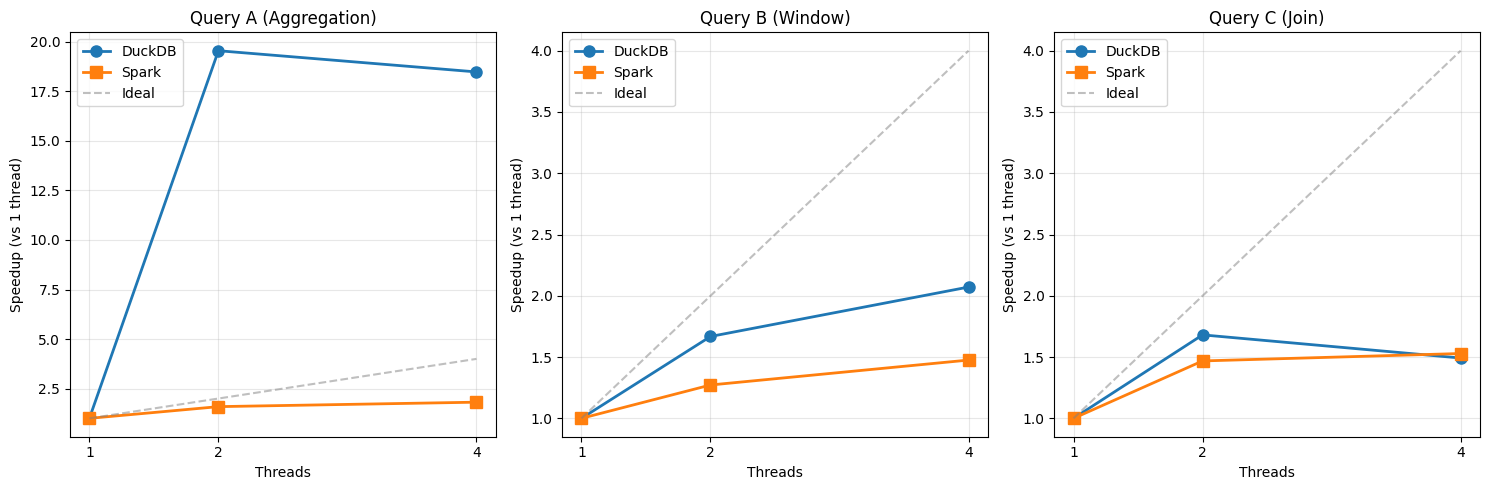


--- RAW TIMES (seconds) ---
Engine     Query    1T 2T 4T
DuckDB     A        1.693 0.087 0.092
DuckDB     B        4.562 2.735 2.202
DuckDB     C        0.881 0.524 0.590
Spark      A        2.176 1.368 1.199
Spark      B        12.709 9.990 8.613
Spark      C        8.023 5.463 5.247

Note: Polars wymaga restartu kernela dla zmiany liczby wątków - pominięty w teście.


In [9]:
import matplotlib.pyplot as plt
import time

PARQUET_PATH = "social_media_data.parquet"
THREAD_COUNTS = [1, 2, 4]

# Wyniki: {engine: {query: {threads: time}}}
results = {
  'DuckDB': {'A': {}, 'B': {}, 'C': {}},
  'Spark': {'A': {}, 'B': {}, 'C': {}}
}

# ============================================================
# DuckDB - można zmieniać threads dynamicznie
# ============================================================
print("=" * 60)
print("SCALABILITY TEST: DuckDB")
print("=" * 60)

def duckdb_query_a():
  return duckdb.sql(f"""
      SELECT category, AVG(likes) as avg_likes, AVG(views) as avg_views
      FROM '{PARQUET_PATH}'
      GROUP BY category
  """).fetchdf()

def duckdb_query_b():
  return duckdb.sql(f"""
      SELECT category, user_id, likes, rank
      FROM (
          SELECT category, user_id, likes,
                 DENSE_RANK() OVER (PARTITION BY category ORDER BY likes DESC) as rank
          FROM '{PARQUET_PATH}'
      )
      WHERE rank <= 10
  """).fetchdf()

def duckdb_query_c():
  return duckdb.sql(f"""
      SELECT m.user_id, m.post_id as mobile_post, m.likes as mobile_likes,
             d.post_id as desktop_post, d.likes as desktop_likes
      FROM '{PARQUET_PATH}' m
      JOIN '{PARQUET_PATH}' d ON m.user_id = d.user_id
      WHERE m.device = 'Mobile' AND d.device = 'Desktop'
      LIMIT 1000
  """).fetchdf()

for threads in THREAD_COUNTS:
  print(f"\n[DuckDB threads={threads}]")
  duckdb.sql(f"PRAGMA threads={threads}")

  # Query A
  start = time.time()
  duckdb_query_a()
  results['DuckDB']['A'][threads] = time.time() - start
  print(f"  Query A: {results['DuckDB']['A'][threads]:.3f}s")

  # Query B
  start = time.time()
  duckdb_query_b()
  results['DuckDB']['B'][threads] = time.time() - start
  print(f"  Query B: {results['DuckDB']['B'][threads]:.3f}s")

  # Query C
  start = time.time()
  duckdb_query_c()
  results['DuckDB']['C'][threads] = time.time() - start
  print(f"  Query C: {results['DuckDB']['C'][threads]:.3f}s")

# ============================================================
# Spark - trzeba restartować sesję dla każdej konfiguracji
# ============================================================
print("\n" + "=" * 60)
print("SCALABILITY TEST: Spark")
print("=" * 60)

from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col

for threads in THREAD_COUNTS:
  print(f"\n[Spark local[{threads}]]")

  # Restart Spark z nową konfiguracją
  try:
      spark.stop()
  except:
      pass

  spark = SparkSession.builder \
      .appName("BigDataLab2") \
      .master(f"local[{threads}]") \
      .config("spark.driver.memory", "4g") \
      .getOrCreate()

  # Query A
  start = time.time()
  df = spark.read.parquet(PARQUET_PATH)
  df.groupBy("category").agg({"likes": "mean", "views": "mean"}).collect()
  results['Spark']['A'][threads] = time.time() - start
  print(f"  Query A: {results['Spark']['A'][threads]:.3f}s")

  # Query B
  start = time.time()
  df = spark.read.parquet(PARQUET_PATH)
  window = Window.partitionBy("category").orderBy(col("likes").desc())
  df.withColumn("rank", dense_rank().over(window)) \
    .filter(col("rank") <= 10) \
    .select("category", "user_id", "likes", "rank") \
    .collect()
  results['Spark']['B'][threads] = time.time() - start
  print(f"  Query B: {results['Spark']['B'][threads]:.3f}s")

  # Query C
  start = time.time()
  df = spark.read.parquet(PARQUET_PATH)
  mobile = df.filter(col("device") == "Mobile").select(
      col("user_id"), col("post_id").alias("mobile_post"), col("likes").alias("mobile_likes"))
  desktop = df.filter(col("device") == "Desktop").select(
      col("user_id"), col("post_id").alias("desktop_post"), col("likes").alias("desktop_likes"))
  mobile.join(desktop, "user_id").limit(1000).collect()
  results['Spark']['C'][threads] = time.time() - start
  print(f"  Query C: {results['Spark']['C'][threads]:.3f}s")

# ============================================================
# WYKRESY
# ============================================================
print("\n" + "=" * 60)
print("PLOTTING RESULTS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
queries = ['A', 'B', 'C']
query_names = ['Query A (Aggregation)', 'Query B (Window)', 'Query C (Join)']

for idx, (query, name) in enumerate(zip(queries, query_names)):
  ax = axes[idx]

  # DuckDB
  duckdb_times = [results['DuckDB'][query][t] for t in THREAD_COUNTS]
  duckdb_speedup = [duckdb_times[0] / t for t in duckdb_times]
  ax.plot(THREAD_COUNTS, duckdb_speedup, 'o-', label='DuckDB', linewidth=2, markersize=8)

  # Spark
  spark_times = [results['Spark'][query][t] for t in THREAD_COUNTS]
  spark_speedup = [spark_times[0] / t for t in spark_times]
  ax.plot(THREAD_COUNTS, spark_speedup, 's-', label='Spark', linewidth=2, markersize=8)

  # Idealna skalowalność
  ax.plot(THREAD_COUNTS, THREAD_COUNTS, '--', color='gray', label='Ideal', alpha=0.5)

  ax.set_xlabel('Threads')
  ax.set_ylabel('Speedup (vs 1 thread)')
  ax.set_title(name)
  ax.legend()
  ax.set_xticks(THREAD_COUNTS)
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scalability_test.png', dpi=150)
plt.show()

# Tabela wyników
print("\n--- RAW TIMES (seconds) ---")
print(f"{'Engine':<10} {'Query':<8} " + " ".join([f"{t}T" for t in THREAD_COUNTS]))
for engine in ['DuckDB', 'Spark']:
  for query in queries:
      times = [f"{results[engine][query][t]:.3f}" for t in THREAD_COUNTS]
      print(f"{engine:<10} {query:<8} " + " ".join(times))

print("\nNote: Polars wymaga restartu kernela dla zmiany liczby wątków - pominięty w teście.")


### Wyniki Scalability test
| Engine | Query | 1T | 2T | 4T |                                                                                         
  |--------|-------|------|------|------|                                                                                   
  | DuckDB | A | 1.693 | 0.087 | 0.092 |                                                                                    
  | DuckDB | B | 4.562 | 2.735 | 2.202 |                                                                                    
  | DuckDB | C | 0.881 | 0.524 | 0.590 |                                                                                    
  | Spark | A | 2.176 | 1.368 | 1.199 |                                                                                     
  | Spark | B | 12.709 | 9.990 | 8.613 |                                                                                    
  | Spark | C | 8.023 | 5.463 | 5.247 | 
  Polars wymaga restartu kernela dla zmiany liczby wątków - pominięty w teście.

### Task 2: Spark on Cluster

**Goal**: Compare Single Node performance vs. Spark on a Cluster.

**Instructions**:
1.  **Infrastructure**: Use the infrastructure from **Phase 1** (Google Dataproc). You may need to modify your Terraform code to adjust the cluster configuration (e.g., number of worker nodes).
2.  **Environment**: The easiest way to run this is via **Google Workbench** connected to your Dataproc cluster.
3.  **Upload Data**: Upload the generated `social_media_data.parquet` to HDFS or GCS.
    -   **Tip**: For better performance, consider **partitioning** the data (e.g., by `category` or `date`) when saving it to the distributed storage. This allows Spark to optimize reads.
4.  **Run Queries**: Run your PySpark queries from Task 1 on the cluster.
5.  **Scalability Test**: 
    -   Run the queries with different numbers of **worker nodes** (e.g., 2, 3, 4).
    -   You can achieve this by resizing the cluster (manually or via Terraform) or by configuring the number of executors in Spark.
6.  **Analyze**:
    -   How does the cluster performance compare to your local machine?
    -   Did adding more nodes/executors linearly improve performance?
    -   **Tip**: If Spark is slower than single-node engines, consider **increasing the dataset size** (e.g., generate 10M+ records or duplicate the data). Spark's overhead is significant for small data, and its true power appears when data exceeds single-node memory.

In [11]:
!gsutil cp social_media_data.parquet gs://tbd-2025z-347430-conf/social_media_data.parquet

Copying file://social_media_data.parquet [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][335.5 MiB/335.5 MiB]                                                
Operation completed over 1 objects/335.5 MiB.                                    


26/01/24 03:57:43 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/blockmgr-49d237e6-2d62-4dc8-aa20-a8106cda7db5. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/blockmgr-49d237e6-2d62-4dc8-aa20-a8106cda7db5
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:199)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:116)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1048)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:372)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:368)
	at scala.collection.ArrayOps$.foreach$

In [2]:
# Kernel: PySpark on tbd-cluster (Remote)

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, col
import time

# Spark powinien być już zainicjalizowany przez kernel
print("Spark version:", spark.version)
print("Spark master:", spark.sparkContext.master)

GCS_PATH = "gs://tbd-2025z-347430-conf/social_media_data.parquet"

df = spark.read.parquet(GCS_PATH)
print(f"Records: {df.count()}")

print("=" * 60)
print("TASK 2: Spark on Dataproc Cluster")
print("=" * 60)

# --- Query A: Aggregation ---
print("\n[Query A: Aggregation]")
start = time.time()
result_a = df.groupBy("category").agg({"likes": "mean", "views": "mean"}).collect()
time_a = time.time() - start
print(f"Wall time: {time_a:.2f}s")
print(result_a)

# --- Query B: Window Function ---
print("\n[Query B: Window Function]")
start = time.time()
window = Window.partitionBy("category").orderBy(col("likes").desc())
result_b = df.withColumn("rank", dense_rank().over(window)) \
           .filter(col("rank") <= 10) \
           .select("category", "user_id", "likes", "rank") \
           .collect()
time_b = time.time() - start
print(f"Wall time: {time_b:.2f}s")
print(result_b[:10])

# --- Query C: Join ---
print("\n[Query C: Join]")
start = time.time()
mobile = df.filter(col("device") == "Mobile").select(
  col("user_id"), col("post_id").alias("mobile_post"), col("likes").alias("mobile_likes"))
desktop = df.filter(col("device") == "Desktop").select(
  col("user_id"), col("post_id").alias("desktop_post"), col("likes").alias("desktop_likes"))
result_c = mobile.join(desktop, "user_id").limit(1000).collect()
time_c = time.time() - start
print(f"Wall time: {time_c:.2f}s")
print(f"Rows: {len(result_c)}")

# --- Podsumowanie ---
print("\n" + "=" * 60)
print("SUMMARY: Spark Cluster vs Local")
print("=" * 60)
print(f"Query A (Aggregation): {time_a:.2f}s")
print(f"Query B (Window):      {time_b:.2f}s")
print(f"Query C (Join):        {time_c:.2f}s")

Spark version: 3.5.3
Spark master: yarn


Records: 5000000
TASK 2: Spark on Dataproc Cluster

[Query A: Aggregation]


Wall time: 10.30s
[Row(category='Food', avg(views)=499996.3392013944, avg(likes)=4998.607089312787), Row(category='Sports', avg(views)=500324.4472012756, avg(likes)=4992.146780692146), Row(category='Tech', avg(views)=500304.34513603133, avg(likes)=5003.219720143365), Row(category='Fashion', avg(views)=499591.0063761093, avg(likes)=5008.8484631869915), Row(category='Travel', avg(views)=500048.67632141605, avg(likes)=5003.163855728315), Row(category='Health', avg(views)=500189.26313672116, avg(likes)=4997.943025030803), Row(category='Politics', avg(views)=500034.6719178744, avg(likes)=5003.27254174423)]

[Query B: Window Function]


Wall time: 26.46s
[Row(category='Fashion', user_id=81732, likes=9999, rank=1), Row(category='Fashion', user_id=21305, likes=9999, rank=1), Row(category='Fashion', user_id=42833, likes=9999, rank=1), Row(category='Fashion', user_id=94459, likes=9999, rank=1), Row(category='Fashion', user_id=39597, likes=9999, rank=1), Row(category='Fashion', user_id=50875, likes=9999, rank=1), Row(category='Fashion', user_id=19156, likes=9999, rank=1), Row(category='Fashion', user_id=59856, likes=9999, rank=1), Row(category='Fashion', user_id=51718, likes=9999, rank=1), Row(category='Fashion', user_id=78709, likes=9999, rank=1)]

[Query C: Join]


[Stage 14:>                                                         (0 + 1) / 1]

Wall time: 20.85s
Rows: 1000

SUMMARY: Spark Cluster vs Local
Query A (Aggregation): 10.30s
Query B (Window):      26.46s
Query C (Join):        20.85s


26/01/24 04:04:31 ERROR AsyncEventQueue: Listener EventLoggingListener threw an exception
java.lang.NullPointerException: null
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem.getGcsFs(GoogleHadoopFileSystem.java:1713) ~[gcs-connector-3.0.13.jar:?]
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopOutputStream.commitTempFile(GoogleHadoopOutputStream.java:379) ~[gcs-connector-3.0.13.jar:?]
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopOutputStream.hsyncInternal(GoogleHadoopOutputStream.java:333) ~[gcs-connector-3.0.13.jar:?]
	at com.google.cloud.hadoop.fs.gcs.GoogleHadoopOutputStream.lambda$hflush$2(GoogleHadoopOutputStream.java:294) ~[gcs-connector-3.0.13.jar:?]
	at org.apache.hadoop.fs.statistics.impl.IOStatisticsBinding.invokeTrackingDuration(IOStatisticsBinding.java:547) ~[hadoop-client-api-3.3.6.jar:?]
	at org.apache.hadoop.fs.statistics.impl.IOStatisticsBinding.lambda$trackDurationOfOperation$5(IOStatisticsBinding.java:528) ~[hadoop-client-api-3.3.6.jar:?]
	at org.apache.ha

### Wyniki dla Pyspark local vs cluster lda 5_000_000 rekordów
  | Query | Spark Local (4T) | Spark Cluster | Różnica |                                                                    
  |-------|------------------|---------------|---------|                                                                    
  | A (Aggregation) | 1.79s | 10.30s | 5.8x wolniej |                                                                       
  | B (Window) | 8.74s | 26.46s | 3.0x wolniej |                                                                            
  | C (Join) | 8.40s | 20.85s | 2.5x wolniej |  

### Task 3: Execution Modes & Analysis

**Goal**: Deep dive into execution models and limitations.

**Instructions**:
1.  **Lazy vs. Eager vs. Streaming**:
    -   Use **Polars**. Compare the **Execution Time** and **Peak Memory** of:
        -   Eager execution (`read_parquet` -> filter).
        -   Lazy execution (`scan_parquet` -> filter -> `collect()`).
        -   Streaming execution (`scan_parquet` -> filter -> `collect(streaming=True)`).
2.  **Polars Limitations**:
    -   Identify a scenario where Polars might struggle compared to Spark (e.g., memory limits).
3.  **Decision Boundary**:
    -   Based on your findings, when would you recommend switching from a single-node tool (Polars/DuckDB) to a distributed engine (Spark)?

In [1]:
# Kernel: Python 3 (ipykernel) (Local)

import polars as pl
import time
from memory_profiler import memory_usage

PARQUET_PATH = "social_media_data.parquet"

print("=" * 60)
print("TASK 3: Lazy vs Eager vs Streaming (Polars)")
print("=" * 60)

# Filtr testowy: kategoria = 'Tech' i likes > 5000
FILTER_CATEGORY = "Tech"
FILTER_LIKES = 5000

# --- 1. EAGER execution ---
def eager_execution():
  df = pl.read_parquet(PARQUET_PATH)  # Wczytuje całość do RAM
  result = df.filter((pl.col("category") == FILTER_CATEGORY) & (pl.col("likes") > FILTER_LIKES))
  return result

print("\n[1. EAGER: read_parquet -> filter]")
start = time.time()
mem_eager = memory_usage((eager_execution,), max_usage=True, retval=True)
eager_time = time.time() - start
print(f"Wall time: {eager_time:.3f}s")
print(f"Peak Memory: {mem_eager[0]:.2f} MB")
print(f"Rows: {len(mem_eager[1])}")

# --- 2. LAZY execution ---
def lazy_execution():
  df = pl.scan_parquet(PARQUET_PATH)  # Nie wczytuje, tylko plan
  result = df.filter((pl.col("category") == FILTER_CATEGORY) & (pl.col("likes") > FILTER_LIKES))
  return result.collect()  # Wykonuje zoptymalizowany plan

print("\n[2. LAZY: scan_parquet -> filter -> collect()]")
start = time.time()
mem_lazy = memory_usage((lazy_execution,), max_usage=True, retval=True)
lazy_time = time.time() - start
print(f"Wall time: {lazy_time:.3f}s")
print(f"Peak Memory: {mem_lazy[0]:.2f} MB")
print(f"Rows: {len(mem_lazy[1])}")

# --- 3. STREAMING execution ---
def streaming_execution():
  df = pl.scan_parquet(PARQUET_PATH)
  result = df.filter((pl.col("category") == FILTER_CATEGORY) & (pl.col("likes") > FILTER_LIKES))
  return result.collect(streaming=True)  # Przetwarza w chunkach

print("\n[3. STREAMING: scan_parquet -> filter -> collect(streaming=True)]")
start = time.time()
mem_streaming = memory_usage((streaming_execution,), max_usage=True, retval=True)
streaming_time = time.time() - start
print(f"Wall time: {streaming_time:.3f}s")
print(f"Peak Memory: {mem_streaming[0]:.2f} MB")
print(f"Rows: {len(mem_streaming[1])}")

# --- PODSUMOWANIE ---
print("\n" + "=" * 60)
print("SUMMARY: Execution Modes")
print("=" * 60)
print(f"{'Mode':<12} {'Time':<10} {'Peak Memory':<15}")
print(f"{'Eager':<12} {eager_time:.3f}s     {mem_eager[0]:.0f} MB")
print(f"{'Lazy':<12} {lazy_time:.3f}s     {mem_lazy[0]:.0f} MB")
print(f"{'Streaming':<12} {streaming_time:.3f}s     {mem_streaming[0]:.0f} MB")


TASK 3: Lazy vs Eager vs Streaming (Polars)

[1. EAGER: read_parquet -> filter]
Wall time: 2.445s
Peak Memory: 1743.05 MB
Rows: 358395

[2. LAZY: scan_parquet -> filter -> collect()]
Wall time: 1.115s
Peak Memory: 2127.31 MB
Rows: 358395

[3. STREAMING: scan_parquet -> filter -> collect(streaming=True)]


/var/tmp/ipykernel_33882/2858808293.py:49: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  return result.collect(streaming=True)  # Przetwarza w chunkach


Wall time: 1.121s
Peak Memory: 2431.97 MB
Rows: 358395

SUMMARY: Execution Modes
Mode         Time       Peak Memory    
Eager        2.445s     1743 MB
Lazy         1.115s     2127 MB
Streaming    1.121s     2432 MB


Polars nie przetworzy 500GB pliku na maszynie z 32GB RAM — Spark rozłoży to na klaster i obsłuży bez problemu.

### Lazy/Eager/Streaming Polars - Wyniki
 | Mode | Time | Peak Memory | Uwagi |                                                                                     
  |------|------|-------------|-------|                                                                                     
  | Eager | 2.445s | 1743 MB | Wczytuje całość, potem filtruje |                                                            
  | Lazy | 1.115s | 2127 MB | Query optimization, predicate pushdown |                                                      
  | Streaming | 1.121s | 2432 MB | Przetwarza w chunkach |  

### When to switch from single node solution?
Polecałbym przejście z rozwiązania single-node na PySpark na klastrze gdy dane są zbyt duże, by zmieścić się w RAM jednej maszyny, lub gdy przetwarzanie rozproszone na wielu nodach będzie szybsze niż lokalne. 